# Teoria Moderna de Portfolio y Optimizacion

La **teoría moderna del portafolio** (Modern portfolio theory) examina cómo inversores conservadores pueden construir carteras de activos para optimizar o maximizar su retorno esperado en función del nivel de riesgo de mercado que estén dispuestos a asumir. Bajo este punto de vista una alta rentabilidad va necesariamente acompañada de un nivel más alto de riesgo.

En este caso utilizamos datos de varios activos que conforman el indice MERVAL y tomamos como fecha de inicio el 01/01/2014. **Tener en cuenta que los datos fueron obtenidos del Yahoo Finance y pueden estar sujetos a errores debido a que no pasaron por 
un proceso de limpieza riguroso.**

Ademas de obtener carteras eficientes segun media-varianza y optimizarlas segun **mayor Sharpe Ratio** y **menor varianza**, tambien se realizara un test de normalidad (a diferencia del otro archivo, estos datos seran importados desde un API y no un CSV).

### Importamos los paquetes y librerias necesarias para el analisis

In [1]:
import numpy as np
np.random.seed(1000)
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\david\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Importamos pandas y su extension para agarrar datos del API de Yahoo Finance

In [2]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as pdr

In [3]:
import fix_yahoo_finance as fyf
from pandas_datareader import data as pdr
fyf.pdr_override()

### Creo una lista con los tickers de los activos a extraer de Yahoo Finance

In [4]:
symbols = ['ALUA.BA','APBR.BA','BMA.BA', 'COME.BA', 'CRES.BA', 'DGCU2.BA', 'EDN.BA','GGAL.BA', 'METR.BA', 'MIRG.BA', 'PAMP.BA', 'TECO2.BA', 'TGNO4.BA', 'TGSU2.BA', 'TRAN.BA', 'TS.BA', 'TXAR.BA', 'YPFD.BA']
noa = len(symbols)

### Obtengo los datos de  Yahoo a partir del 01/01/2014

Uso .tail() para observar las ultimas 5 filas de los datos y corroborar que las fechas extraidas esten bien

In [5]:
data = pdr.get_data_yahoo(symbols, start='2014-01-01')
data.tail()

[*********************100%***********************]  18 of 18 downloaded


Open                                                        \
              ALUA.BA     APBR.BA      BMA.BA COME.BA    CRES.BA   DGCU2.BA   
Date                                                                          
2018-10-01  22.600000  249.500000  170.500000    4.48  58.000000  51.000000   
2018-10-02  21.100000  243.149994  171.449997    4.44  56.000000  49.000000   
2018-10-03  20.799999  262.000000  171.050003    4.31  52.049999  49.000000   
2018-10-04  22.200001  254.000000  165.899994    4.18  52.299999  47.450001   
2018-10-05  21.600000  269.950012  158.000000    4.18  51.900002  45.599998   

                                                           ...    Volume  \
               EDN.BA     GGAL.BA    METR.BA     MIRG.BA   ...   METR.BA   
Date                                                       ...             
2018-10-01  51.299999  105.699997  37.700001  371.000000   ...    113735   
2018-10-02  49.750000  105.949997  35.950001  350.100006   ...    115421   
2018-10-03  49.200001  107.550003  36.099998  380.000000   ...    144012   
2018-10-04  47.000000  100.000000  36.000000  360.000000   ...     85057   
2018-10-05  44.349998   95.250000  34.849998  365.000000   ...     71628   

                                                                               \
           MIRG.BA  PAMP.BA TECO2.BA TGNO4.BA TGSU2.BA TRAN.BA  TS.BA TXAR.BA   
Date                                                                            
2018-10-01    4543   435649   128272   252771   254746  380623  33528       0   
2018-10-02    8916   871957    86008   138957   264902  389973  43261       0   
2018-10-03   10054   656799   152360   159424   180985  251442  24757       0   
2018-10-04    9651  1118014   126659   104934   548708  275017  24495       0   
2018-10-05   16751  1236570   132525   226205   367285  284152  16986  558238   

                    
           YPFD.BA  
Date                
2018-10-01  104352  
2018-10-02   98783  
2018-10-03  101915  
2018-10-04  102130  
2018-10-05   80689  

[5 rows x 108 columns]

### Creo un pandas Dataframe df1 y le agrego solo la columna de cierres ajustados extraidos de yahoo

Aparte, uso **.isnull().any()** para observar si faltan valores. False=No True=Si

In [6]:
df1 = pd.DataFrame()
df1 = data['Adj Close']
df1.isnull().any()

ALUA.BA     False
APBR.BA     False
BMA.BA      False
COME.BA     False
CRES.BA     False
DGCU2.BA    False
EDN.BA      False
GGAL.BA     False
METR.BA     False
MIRG.BA     False
PAMP.BA     False
TECO2.BA    False
TGNO4.BA    False
TGSU2.BA    False
TRAN.BA     False
TS.BA       False
TXAR.BA     False
YPFD.BA     False
dtype: bool

### Mido la cantidad de valores en la variable df1 y la comparo con df1, borrando los valores NaN.

Como observamos, al no tener valores faltantes, la cantidad es igual para ambos casos.

In [7]:
len(df1)

1169

In [8]:
len(df1.dropna())

1169

### Grafico los cierres normalizados para todos los activos

Normalizar la serie sirve para poder comparar entre diferentes activos ya que todos comienzan del mismo punto.

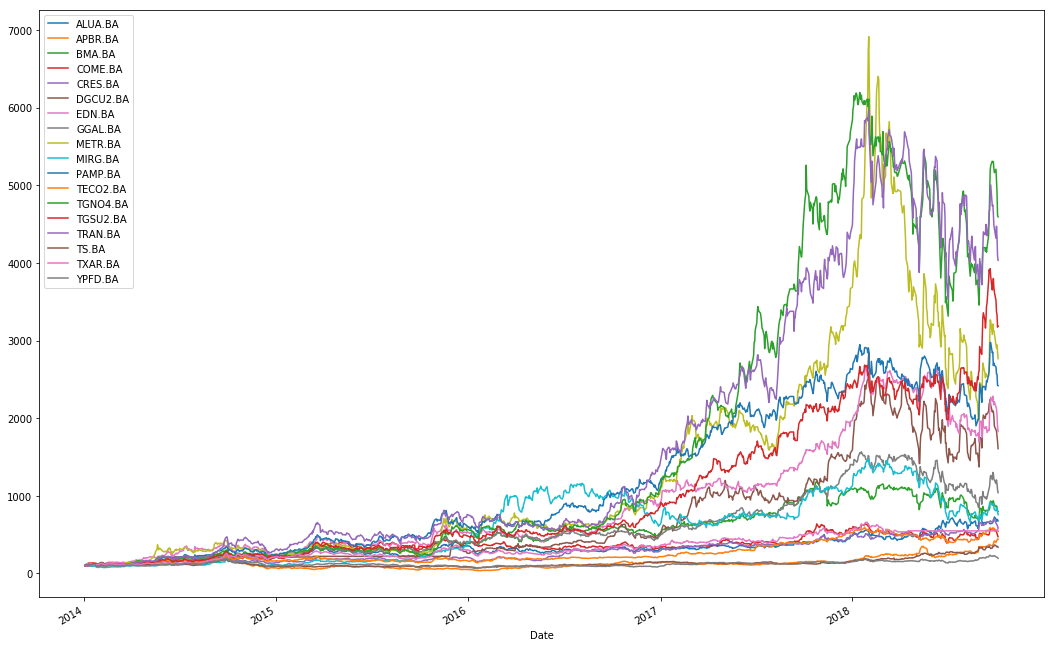

In [9]:
(df1 / df1.iloc[0] * 100).plot(figsize=(18, 12))

### Calculo los retornos logaritmicos para cada activo

Uso **.shift(1)** para indicar que divido el cierre con el cierre de t-1.
Ademas utilizamos **.head()** para vizualizar las 5 primeras filas de los retornos logaritmicos calculados para todos los activos.

In [10]:
log_returns = np.log(df1 / df1.shift(1))
log_returns.head()

,ALUA.BA,APBR.BA,BMA.BA,COME.BA,CRES.BA,DGCU2.BA,EDN.BA,GGAL.BA,METR.BA,MIRG.BA,PAMP.BA,TECO2.BA,TGNO4.BA,TGSU2.BA,TRAN.BA,TS.BA,TXAR.BA,YPFD.BA
Date,,,,,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,-0.019100,-0.025318,-0.026223,0.051576,0.011561,0.0,0.132992,0.005571,0.078781,0.005794,0.046281,-0.020691,0.067951,0.045523,0.120836,0.012903,-0.010017,0.000000
2014-01-06,-0.022286,0.008511,-0.034402,0.041894,0.033903,0.0,0.100443,-0.033902,0.015038,-0.009067,-0.020305,-0.024693,0.021661,-0.005250,0.008097,-0.025975,-0.013514,0.000000
2014-01-07,0.002813,0.000000,0.034402,0.138639,0.000000,0.0,-0.100443,0.028330,0.014815,-0.039002,-0.025975,0.082238,-0.043802,-0.013245,-0.024491,0.002628,0.013514,0.022167
2014-01-08,-0.022728,-0.017094,0.014389,0.043674,-0.044300,0.0,0.018692,0.013319,-0.014815,-0.015268,0.005249,0.009820,0.022141,0.013245,0.016394,-0.002628,0.003350,0.000168


### Graficamos un histograma de los retornos para observar sus distribuciones

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A12D3C0048>,
      dtype=object)

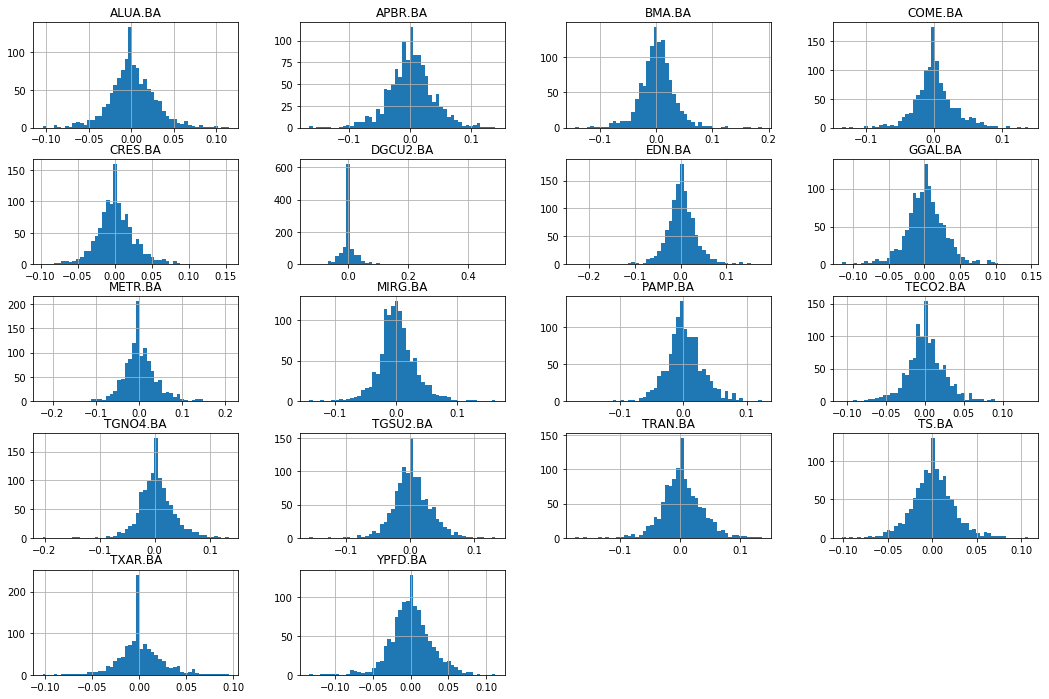

In [11]:
log_returns.hist(bins=50, figsize=(18, 12))

### Graficamos el quantile-quantile

En este caso utilizamos YPFD como ejemplo pero lo podemos hacer con cualquiera. Al observar que los puntos no estan todos sobre la recta, entendemos que no hay distribucion normal. Los puntos por arriba y abajo indican que hay presencia de fat-tails.

Text(0,0.5,'sample quantiles')

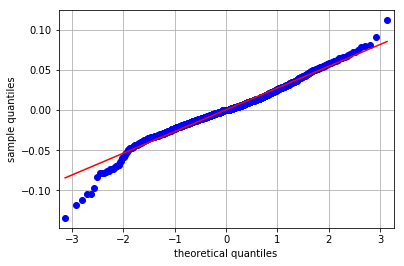

In [12]:
sm.qqplot(log_returns['YPFD.BA'].dropna(), line='s')
plt.grid(True)
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')

### Calculamos la media de los retornos para todos los activos y lo anualizamos

In [13]:
log_returns.mean() * 252

ALUA.BA     0.412250
APBR.BA     0.320034
BMA.BA      0.448021
COME.BA     0.335072
CRES.BA     0.380929
DGCU2.BA    0.599028
EDN.BA      0.626889
GGAL.BA     0.505257
METR.BA     0.716329
MIRG.BA     0.436534
PAMP.BA     0.687326
TECO2.BA    0.364784
TGNO4.BA    0.825683
TGSU2.BA    0.746700
TRAN.BA     0.797613
TS.BA       0.262472
TXAR.BA     0.382870
YPFD.BA     0.143082
dtype: float64

### Calculamos la covarianza de los retornos entre los activos y la anualizamos

In [14]:
log_returns.cov() * 252

,ALUA.BA,APBR.BA,BMA.BA,COME.BA,CRES.BA,DGCU2.BA,EDN.BA,GGAL.BA,METR.BA,MIRG.BA,PAMP.BA,TECO2.BA,TGNO4.BA,TGSU2.BA,TRAN.BA,TS.BA,TXAR.BA,YPFD.BA
ALUA.BA,0.180091,0.085169,0.088073,0.095904,0.069547,0.043028,0.083300,0.086951,0.105480,0.072424,0.095207,0.067111,0.089809,0.087748,0.118488,0.050951,0.105486,0.087157
APBR.BA,0.085169,0.352003,0.067359,0.086190,0.063479,0.010397,0.061142,0.065729,0.063517,0.048495,0.080216,0.070011,0.059690,0.068909,0.079746,0.115004,0.063409,0.117280
BMA.BA,0.088073,0.067359,0.241709,0.110366,0.085026,0.059365,0.145062,0.181634,0.132723,0.084928,0.145877,0.099193,0.118955,0.112089,0.142575,0.036979,0.074866,0.110646
COME.BA,0.095904,0.086190,0.110366,0.214930,0.071175,0.055318,0.113588,0.111942,0.130648,0.092691,0.118518,0.075830,0.103494,0.095873,0.145673,0.040259,0.082052,0.099833
CRES.BA,0.069547,0.063479,0.085026,0.071175,0.173475,0.034126,0.084951,0.077594,0.076593,0.050818,0.084986,0.052957,0.070571,0.075994,0.090145,0.043826,0.062032,0.072458
DGCU2.BA,0.043028,0.010397,0.059365,0.055318,0.034126,0.254525,0.053148,0.062735,0.115134,0.071103,0.057041,0.018753,0.093067,0.052413,0.086984,-0.002812,0.019091,0.027177
EDN.BA,0.083300,0.061142,0.145062,0.113588,0.084951,0.053148,0.279009,0.137385,0.154661,0.081779,0.173474,0.092008,0.137193,0.123100,0.171096,0.041014,0.084969,0.108197
GGAL.BA,0.086951,0.065729,0.181634,0.111942,0.077594,0.062735,0.137385,0.207452,0.136336,0.093549,0.140364,0.096501,0.119861,0.115988,0.147345,0.035172,0.074231,0.110547
METR.BA,0.105480,0.063517,0.132723,0.130648,0.076593,0.115134,0.154661,0.136336,0.382960,0.112258,0.138908,0.080326,0.176689,0.119705,0.194455,0.031068,0.083518,0.102757
MIRG.BA,0.072424,0.048495,0.084928,0.092691,0.050818,0.071103,0.081779,0.093549,0.112258,0.242240,0.082951,0.057375,0.092220,0.078432,0.112844,0.013148,0.058462,0.070832


### Creo la variable de pesos para la poderacion de activos en la cartera

Partimos de la premisa que solo podemos tener posiciones long ya que en Argentina no se pueden shortear acciones. El codigo crea numeros aleatorios entre 0 y 1, luego los normaliza para que la suma de todos sea 1. Esto permite que el total sea 100%, dejando de lado el apalancamiento en este caso.

In [15]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([0.07283373, 0.01281597, 0.10589619, 0.05373372, 0.09722551,
       0.02366161, 0.00453654, 0.04426196, 0.02597944, 0.09380064,
       0.02307653, 0.0827382 , 0.04370028, 0.02031003, 0.08285743,
       0.00775398, 0.09865888, 0.10615936])

### Calculamos el retorno esperado para el portfolio, anualizado y con los pesos aleatorios

In [16]:
np.sum(log_returns.mean() * weights) * 252

0.45392738198758636

### Calculamos la varianza esperada y desvio estandar esperado para el portfolio, anualizados y con los pesos aleatorios

In [17]:
np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))

0.09858498209110526

In [18]:
np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))

0.31398245506891825

### Hacemos una simulacion de montecarlo para crear 2500 carteras con ponderaciones aleatorias

Utilizamos ponderaciones aleatorias, los retornos y la volatilidad son los calculados por los datos historicos.

El risk free para el sharpe ratio utilizado es 0 en este caso.

In [19]:
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(log_returns.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T,
                np.dot(log_returns.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

### Graficamos las 2500 carteras generadas por pesos aleatorios

Estan ubicadas en relacion a su retorno esperado y volatilidad esperada. Los colores ordenan a las mismas carteras por mayor ratio de Sharpe.

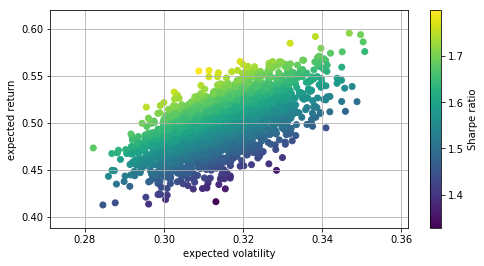

In [20]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

### Definimos la funcion de estadisticas:

Nos va a calcular el retorno esperado, volatilidad esperada y el Ratio de Sharpe. Los primeros 2 anualizados y el el SR el rf=0. Tambien importamos un optimizador para realizar los calculos.

In [21]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(log_returns.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [22]:
import scipy.optimize as sco

### Definimos la funcion para optimizar el portfolio por maximizacion de SR

Va a minimizar el valor negativo del Sharpe Ratio.

In [23]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

### Creamos y aplicamos restricciones

* Los pesos tienen que sumar 1.
* Tiene que estar entre los parametros del 0 y 1.
* La lista de parametros inicial para la ponderacion de pesos va a ser igual para todos (Ej. 1 / 5activos = 0.2 para c/u).

In [24]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
noa * [1. / noa,]

[0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555,
 0.05555555555555555]

### Creamos variable opts donde se guardaran las ponderaciones optimas para maximizar el SR

In [25]:
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                        bounds=bnds, constraints=cons)

### Calculamos la ponderacion optima para el Max SR

Tener en cuenta que el orden de los tickers esta ordenado alfabeticamente

In [26]:
opts['x'].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.006, 0.212, 0.   , 0.   , 0.   ,
       0.   , 0.086, 0.   , 0.25 , 0.277, 0.037, 0.131, 0.001, 0.   ])

### Aplicamos la funcion de estadisticas definida anteriormente

De esta manera tenemos un benchmark comparable por igual entre muchas carteras

* Retorno Esperado Anualizado
* Volatilidad Esperada Anualizada
* Sharpe Ratio

In [27]:
statistics(opts['x']).round(3)

array([0.666, 0.333, 1.999])

### Definimos una funcion para optimizar el portfolio, minimizando la volatilidad

Esta funcion nos va a calcular el portfolio de varianza minima absoluta

In [28]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

### Creamos variable optv donde se guardaran las ponderaciones optimas para minimizar la varianza

In [29]:
optv = sco.minimize(min_func_variance, noa * [1. / noa,],
                        method='SLSQP', bounds=bnds,
                        constraints=cons)

### Calculamos la ponderacion optima para el Min la Varianza

In [30]:
optv['x'].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.111, 0.184, 0.   , 0.   , 0.   ,
       0.084, 0.   , 0.138, 0.   , 0.   , 0.   , 0.294, 0.189, 0.   ])

### Volvemos a aplicar la funcion de estadisticas creadas anteriormente

* Retorno Esperado Anualizado
* Volatilidad Esperada Anualizada
* Sharpe Ratio

De esta manera, podemos comprar que la volatilidad es menor a la cartera que busca max el SR. Pero tambien obtiene un retorno mucho menor. Siendo la cartera mas conservadora.

In [31]:
statistics(optv['x']).round(3)

array([0.389, 0.249, 1.564])